# Working with data matrices and analysis results

This notebook will show the most suitable commands to retrieve data from GrandPy object in different scenarios.

Throughout this notebook, we will be using GRAND-SLAM processed SLAM-seq data set from [Finkel et al. (2021)](https://www.nature.com/articles/s41586-021-03610-3). The data set contains time series (progressive labeling) samples from a human epithelial cell line (Calu3 cells); half of the samples were infedctes with SARS-CoV-2 for different periods of time. For more on these initial commands see the [loading data notebook](../notebook_03_loading_data_and_working_with_grandpy_objects).

In [1]:
import warnings

import grandpy as gp

warnings.filterwarnings("ignore", category=UserWarning)

sars = gp.read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"), classify_genes_func=lambda df: gp.classify_genes(df, cg_name="viral"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.


In [2]:
sars = sars.filter_genes()

# Data slots
Data is organized in `slots`:

In [3]:
sars.slots

['ntr', 'alpha', 'beta', 'count']

To learn more about metadata, see the [loading data notebook](../notebook_03_loading_data_and_working_with_grandpy_objects). After loading GRAND-SLAM analysis results, the standard slots are "count" (read counts), "ntr" (the new-to-total RNA ratio), "alpha" and "beta" (the parameters for the Beta approximation of the NTR posterior distribution). Each of these slots contains a genes x columns matrix of numeric values. (columns are either samples or cells, depending on whether your data is bulk or single cell data)

There is also a `default_slot`, which is used by many functions as a default parameter.

In [4]:
sars.default_slot

'count'

New slots are added by specific GrandPy methods such as `normalize()` or `normalize_tpm()`, which change the `default_slot`. It can also be set manually.

In [5]:
sars = sars.normalize()
sars.default_slot

'norm'

In [6]:
sars = sars.with_default_slot("count")
sars.default_slot

'count'

In [7]:
sars = sars.normalize_tpm(set_to_default = False)
sars.default_slot

'count'

In [8]:
sars = sars.with_default_slot("norm")
sars.default_slot

'norm'

There are also other GrandPy functions that add additional slots, but do not update the `default_slot` automatically:

In [9]:
sars = sars.compute_ntr_ci()
sars.default_slot

'norm'

In [10]:
sars.slots

['ntr', 'alpha', 'beta', 'count', 'norm', 'tpm', 'lower', 'upper']

# Analysis
In addition to data slots, there is an additional kind of data that is part of a GrandPy object: analyses.

In [11]:
sars.analyses

[]

After loading data there are no analyses, but such data is added e.g. by performing modeling of progressive labeling time courses or analyzing gene expression (see the notebooks [kinetic modeling](../notebook_02_kinetic_modeling) and [differential expression](../notebook_01_differential_expression) for more on these)

In [12]:
sars = sars.fit_kinetics(steady_state = {"Mock": True, "SARS": False})
sars = sars.compute_lfc(contrasts = sars.get_contrasts(contrast = ["duration.4sU.original", "no4sU"], group = "Condition", no4su = True))
sars.analyses

Fitting SARS: 100%|██████████| 9162/9162 [00:11<00:00, 769.97it/s] 
C:\Users\user\PycharmProjects\grandpy\grandpy\lfc.py:35: RuntimeWarning: divide by zero encountered in log
  diff = np.log(A0) - np.log(B0)
C:\Users\user\PycharmProjects\grandpy\grandpy\lfc.py:35: RuntimeWarning: divide by zero encountered in log
  diff = np.log(A0) - np.log(B0)
C:\Users\user\PycharmProjects\grandpy\grandpy\lfc.py:35: RuntimeWarning: divide by zero encountered in log
  diff = np.log(A0) - np.log(B0)
C:\Users\user\PycharmProjects\grandpy\grandpy\lfc.py:35: RuntimeWarning: divide by zero encountered in log
  diff = np.log(A0) - np.log(B0)


['kinetics_Mock',
 'kinetics_SARS',
 'total_1h vs no4sU.Mock',
 'total_2h vs no4sU.Mock',
 'total_3h vs no4sU.Mock',
 'total_4h vs no4sU.Mock',
 'total_1h vs no4sU.SARS',
 'total_2h vs no4sU.SARS',
 'total_3h vs no4sU.SARS',
 'total_4h vs no4sU.SARS']

Both analysis methods, `fit_kinetics()` and `compute_lfc()` added multiple analyses: `fit_kinetics()` added an analysis for each `condition` whereas `compute_lfc()` added an analysis for each pairwise comparison defined by `get_contrasts()` (see [differential expression](../notebook_01_differential_expression) for details).

What is common to data slots and analyses is that both are tables with as many rows as there are genes. The main difference are their columns. In `slots` the columns correspond to the samples or cells (depending on whether the data is bulk or single cell data). In `analyses` the columns are arbitrary, only depending on the kind of analysis performed.

Analysis columns can be retrieved by setting the `description` to 'True' for `get_analyses()`:

In [13]:
sars.get_analyses(description = True)

{'kinetics_Mock': ['Synthesis', 'Half-life'],
 'kinetics_SARS': ['Synthesis', 'Half-life'],
 'total_1h vs no4sU.Mock': ['LFC', 'M'],
 'total_2h vs no4sU.Mock': ['LFC', 'M'],
 'total_3h vs no4sU.Mock': ['LFC', 'M'],
 'total_4h vs no4sU.Mock': ['LFC', 'M'],
 'total_1h vs no4sU.SARS': ['LFC', 'M'],
 'total_2h vs no4sU.SARS': ['LFC', 'M'],
 'total_3h vs no4sU.SARS': ['LFC', 'M'],
 'total_4h vs no4sU.SARS': ['LFC', 'M']}

We see that `fit_kinetics()` by default creates tables with two columns (*Synthesis* and *Half-life*) corresponding to the synthesis rate and RNA half-life for each gene. `compute_lfc()` also creates 2 columns by default: *LFC*, the log2 fold changes for each gene and *M*, the base mean.

# Retrieving data from slots and analyses
There are two main methods you can use for retrieving the data from `slots`:
- `get_table()`: Returns a DataFrame containing slot data (genes x samples/cells)
- `get_data()`: Returns a DataFrame containing slot data (samples/cells x genes)

For data from `analyses` there is only one:
- `get_analysis_table()`: Returns a DataFrame containing analysis results (genes x analysis names)

# get_table
Without any other parameters `get_table()` returns the data from `default_slot` for all genes:

In [14]:
sars.get_table().head()

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,50.589820,138.959046,152.695298,100.268518,116.221304,127.814358,175.300406,210.686292,275.421810,190.070456,231.723678,191.991623
OSBPL9,483.012448,397.687556,386.869134,467.120508,429.751503,422.137765,475.815389,407.326831,399.101793,435.912760,340.633807,348.220100
BTF3L4,579.373768,399.727839,303.235621,545.555207,527.451230,417.719867,500.858304,432.102017,269.878764,447.438971,382.344069,399.041412
ZFYVE9,186.098266,160.795468,157.347291,158.903803,128.187134,132.079914,237.907694,193.129101,168.371069,211.040671,192.330653,203.285248
PRPF38A,359.549076,310.341870,335.765466,364.890215,329.951391,362.876996,500.858304,278.574097,309.719620,366.309494,315.144202,313.398090


You can change the slot by specifying the `mode_slot`.

In [15]:
sars.get_table(mode_slot = "count").head()

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,14.0000,420.0000,372.0000,230.0000,456.50,419.5,14.0,180.0000,265.0000,213.0000,100.0,102.0
OSBPL9,133.6667,1202.0000,942.5000,1071.5000,1688.00,1385.5,38.0,348.0000,384.0000,488.5000,147.0,185.0
BTF3L4,160.3333,1208.1667,738.7500,1251.4167,2071.75,1371.0,40.0,369.1667,259.6667,501.4167,165.0,212.0
ZFYVE9,51.5000,486.0000,383.3333,364.5000,503.50,433.5,19.0,165.0000,162.0000,236.5000,83.0,108.0
PRPF38A,99.5000,938.0000,818.0000,837.0000,1296.00,1191.0,40.0,238.0000,298.0000,410.5000,136.0,166.5


Multiple slots can be used at once:

In [16]:
sars.get_table(mode_slot = ["norm", "count"]).columns

Index(['Mock.no4sU.A_norm', 'Mock.1h.A_norm', 'Mock.2h.A_norm',
       'Mock.2h.B_norm', 'Mock.3h.A_norm', 'Mock.4h.A_norm',
       'SARS.no4sU.A_norm', 'SARS.1h.A_norm', 'SARS.2h.A_norm',
       'SARS.2h.B_norm', 'SARS.3h.A_norm', 'SARS.4h.A_norm',
       'Mock.no4sU.A_count', 'Mock.1h.A_count', 'Mock.2h.A_count',
       'Mock.2h.B_count', 'Mock.3h.A_count', 'Mock.4h.A_count',
       'SARS.no4sU.A_count', 'SARS.1h.A_count', 'SARS.2h.A_count',
       'SARS.2h.B_count', 'SARS.3h.A_count', 'SARS.4h.A_count'],
      dtype='object')

By using the `mode_slot` syntax (mode being either of *total*, *new* and *old*), you can also retrieve new RNA counts or new RNA normalized values:

In [17]:
sars.get_table(mode_slot="new_norm").head()

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,NaN,2.334512,32.111821,16.474117,40.421769,52.710641,NaN,10.323628,68.111814,39.002458,110.740746,116.596513
OSBPL9,NaN,17.339177,55.206225,62.407300,82.942040,109.840247,NaN,49.245814,154.332663,181.601256,169.226875,224.636787
BTF3L4,NaN,17.308215,69.380310,120.949589,177.434594,223.605445,NaN,40.315118,101.825258,177.588528,194.957241,232.641143
ZFYVE9,NaN,2.267216,27.897675,25.821868,39.302175,68.879675,NaN,3.283195,56.454819,66.815476,100.915894,144.312197
PRPF38A,NaN,28.737657,122.185053,133.987687,160.389371,252.489814,NaN,82.290788,223.122015,235.903314,231.851590,285.286282


A mode slot can also be specified using a `ModeSlot` object, as you will see in the following example.

Note that the no4sU columns contain only NaN values. You can change this behavior by specifying `ntr_nan`:

In [18]:
sars.get_table(mode_slot= gp.ModeSlot("new", "norm"), ntr_nan = False).head()

,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,
MIB2,0.0,2.334512,32.111821,16.474117,40.421769,52.710641,0.0,10.323628,68.111814,39.002458,110.740746,116.596513
OSBPL9,0.0,17.339177,55.206225,62.407300,82.942040,109.840247,0.0,49.245814,154.332663,181.601256,169.226875,224.636787
BTF3L4,0.0,17.308215,69.380310,120.949589,177.434594,223.605445,0.0,40.315118,101.825258,177.588528,194.957241,232.641143
ZFYVE9,0.0,2.267216,27.897675,25.821868,39.302175,68.879675,0.0,3.283195,56.454819,66.815476,100.915894,144.312197
PRPF38A,0.0,28.737657,122.185053,133.987687,160.389371,252.489814,0.0,82.290788,223.122015,235.903314,231.851590,285.286282


It is also possible to only retrieve data for specific `columns` (i.e., samples or cells) by using the `columns` parameter. Here you can use column names, their index, or a boolean mask:

In [19]:
sars.get_table(columns = ["Mock.no4sU.A", "SARS.no4sU.A"]).columns

Index(['Mock.no4sU.A', 'SARS.no4sU.A'], dtype='object')

In [20]:
sars.get_table(columns = sars.columns[3:6]).columns

Index(['Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A'], dtype='object')

In [21]:
sars.get_table(columns = (sars.coldata["duration.4sU"] >= 2) & (sars.coldata["Condition"] == "Mock")).columns

Index(['Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A'], dtype='object')

It is furthermore possible to only fetch data for specific genes (e.g. viral genes) using the `genes` parameter. It is either gene names/symbols, their index, or a boolean mask:

In [22]:
sars.get_table(genes = "MYC").index

Index(['MYC'], dtype='object', name='Symbol')

In [23]:
sars.get_table(genes = range(0,3)).index

Index(['MIB2', 'OSBPL9', 'BTF3L4'], dtype='object', name='Symbol')

In [24]:
sars.get_table(genes = (sars.gene_info["Type"] == "viral")).index

Index(['ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF10',
       'ORF1ab', 'S'],
      dtype='object', name='Symbol')

Sometimes, it makes sense to add the `gene_info` to the DataFrame (for more on gene metadata, see the [loading data notebook](../notebook_03_loading_data_and_working_with_grandPy_objects)):

In [25]:
df = sars.get_table(mode_slot = "norm", with_gene_info = True)
df.head()

,Symbol,Gene,Length,Type,Mock.no4sU.A,Mock.1h.A,Mock.2h.A,Mock.2h.B,Mock.3h.A,Mock.4h.A,SARS.no4sU.A,SARS.1h.A,SARS.2h.A,SARS.2h.B,SARS.3h.A,SARS.4h.A
Symbol,,,,,,,,,,,,,,,,
MIB2,MIB2,ENSG00000197530,4247,Cellular,50.589820,138.959046,152.695298,100.268518,116.221304,127.814358,175.300406,210.686292,275.421810,190.070456,231.723678,191.991623
OSBPL9,OSBPL9,ENSG00000117859,4520,Cellular,483.012448,397.687556,386.869134,467.120508,429.751503,422.137765,475.815389,407.326831,399.101793,435.912760,340.633807,348.220100
BTF3L4,BTF3L4,ENSG00000134717,4703,Cellular,579.373768,399.727839,303.235621,545.555207,527.451230,417.719867,500.858304,432.102017,269.878764,447.438971,382.344069,399.041412
ZFYVE9,ZFYVE9,ENSG00000157077,5194,Cellular,186.098266,160.795468,157.347291,158.903803,128.187134,132.079914,237.907694,193.129101,168.371069,211.040671,192.330653,203.285248
PRPF38A,PRPF38A,ENSG00000134748,5274,Cellular,359.549076,310.341870,335.765466,364.890215,329.951391,362.876996,500.858304,278.574097,309.719620,366.309494,315.144202,313.398090


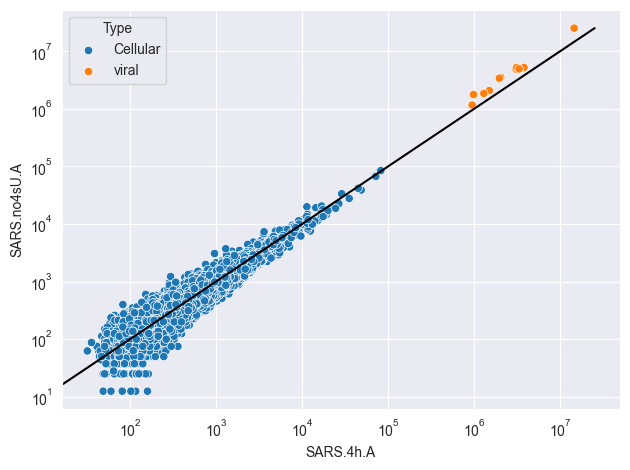

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.scatterplot(
    data=df,
    x='SARS.4h.A',
    y='SARS.no4sU.A',
    hue='Type'
)

plt.xscale('log')
plt.yscale('log')

lims = [
    np.min([df['SARS.4h.A'].min(), df['SARS.no4sU.A'].min()]),
    np.max([df['SARS.4h.A'].max(), df['SARS.no4sU.A'].max()]),
]
plt.plot(lims, lims, 'k-')

plt.xlabel('SARS.4h.A')
plt.ylabel('SARS.no4sU.A')
plt.legend(title='Type')

plt.tight_layout()
plt.show()

Finally, values can be summarized across samples or cells from the same `condition`:

In [27]:
sars.get_table(summarize = sars.get_summarize_matrix()).head()

,Mock,SARS
Symbol,,
MIB2,127.191705,219.978772
OSBPL9,420.713293,386.239058
BTF3L4,438.737953,386.161047
ZFYVE9,147.462722,193.631348
PRPF38A,340.765188,316.629101


This is achieved by a summerize matrix:

In [28]:
sars.get_summarize_matrix()

,Mock,SARS
Mock.no4sU.A,0.0,0.0
Mock.1h.A,0.2,0.0
Mock.2h.A,0.2,0.0
Mock.2h.B,0.2,0.0
Mock.3h.A,0.2,0.0
Mock.4h.A,0.2,0.0
SARS.no4sU.A,0.0,0.0
SARS.1h.A,0.0,0.2
SARS.2h.A,0.0,0.2
SARS.2h.B,0.0,0.2


For summarization, the summarize matrix is matrix-multiplied with the raw matrix. `get_summarized_matrix()` will generate a matrix with a column for each `condition`:

In [29]:
print(sars.condition)

['Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS']


By default, no4sU columns are removed (i.e. zero in the matrix), but the `no4su` parameter can change this:

In [30]:
sars.get_summarize_matrix(no4su = True)

,Mock,SARS
Mock.no4sU.A,0.166667,0.000000
Mock.1h.A,0.166667,0.000000
Mock.2h.A,0.166667,0.000000
Mock.2h.B,0.166667,0.000000
Mock.3h.A,0.166667,0.000000
Mock.4h.A,0.166667,0.000000
SARS.no4sU.A,0.000000,0.166667
SARS.1h.A,0.000000,0.166667
SARS.2h.A,0.000000,0.166667
SARS.2h.B,0.000000,0.166667


It is also possible to only focus on specific columns:

In [31]:
sars.get_summarize_matrix(columns =sars.coldata["duration.4sU"] < 4)

,Mock,SARS
Mock.no4sU.A,0.00,0.00
Mock.1h.A,0.25,0.00
Mock.2h.A,0.25,0.00
Mock.2h.B,0.25,0.00
Mock.3h.A,0.25,0.00
Mock.4h.A,0.00,0.00
SARS.no4sU.A,0.00,0.00
SARS.1h.A,0.00,0.25
SARS.2h.A,0.00,0.25
SARS.2h.B,0.00,0.25


The default behavior is to compute the average, which can be changed to computing sums:

In [32]:
sars.get_summarize_matrix(average = False)

,Mock,SARS
Mock.no4sU.A,0.0,0.0
Mock.1h.A,1.0,0.0
Mock.2h.A,1.0,0.0
Mock.2h.B,1.0,0.0
Mock.3h.A,1.0,0.0
Mock.4h.A,1.0,0.0
SARS.no4sU.A,0.0,0.0
SARS.1h.A,0.0,1.0
SARS.2h.A,0.0,1.0
SARS.2h.B,0.0,1.0


As a final example, let's get the averaged normalized values for only the 2h timepoint:

In [33]:
sars.get_table(summarize=sars.get_summarize_matrix(columns=sars.coldata["duration.4sU"] == 2)).head()

,Mock,SARS
Symbol,,
MIB2,126.481908,232.746133
OSBPL9,426.994821,417.507276
BTF3L4,424.395414,358.658868
ZFYVE9,158.125547,189.705870
PRPF38A,350.327840,338.014557


# get_data
`get_data()` is very similar to `get_table()`. The most important difference is its shape. The output is transposed relative to `get_table()`.

In [34]:
sars.get_data(genes = "MYC")

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,MYC
Symbol,,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True,1546.603063
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False,1577.626303
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False,2543.484978
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False,1927.771241
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False,2127.583927
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False,2048.381231
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True,3430.879383
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False,2230.933733
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False,5206.511539


Note that here the `coldata` can be added, which is also the default behavior (for more on column metadata, see the [loading data notebook](../notebook_03_loading_data_and_working_with_grandPy_objects)). This can be changed by using the `with_coldata` parameter:

In [35]:
sars.get_data(genes = "MYC", with_coldata = False)

,MYC
Symbol,
Mock.no4sU.A,1546.603063
Mock.1h.A,1577.626303
Mock.2h.A,2543.484978
Mock.2h.B,1927.771241
Mock.3h.A,2127.583927
Mock.4h.A,2048.381231
SARS.no4sU.A,3430.879383
SARS.1h.A,2230.933733
SARS.2h.A,5206.511539


The `genes`, `columns` and `mode_slot` parameters work just like they do in `get_table()`.

In [36]:
sars.get_data(mode_slot = ["count", "norm"], genes = ["MYC", "SRSF6"], columns = sars.coldata["Condition"] == "Mock", with_coldata = False)

,MYC_count,SRSF6_count,MYC_norm,SRSF6_norm
Symbol,,,,
Mock.no4sU.A,428.0000,367.5000,1546.603063,1327.982770
Mock.1h.A,4768.3333,3607.0000,1577.626303,1193.393522
Mock.2h.A,6196.5000,2972.5000,2543.484978,1220.125732
Mock.2h.B,4422.0000,3272.0000,1927.771241,1426.428652
Mock.3h.A,8356.8333,4747.3333,2127.583927,1208.633661
Mock.4h.A,6723.0000,3799.5000,2048.381231,1157.641602


Finally, it is also possible to add multiple genes (and/or slots) not as columns, but as additional rows:

In [37]:
sars.get_data(genes = ["MYC", "SRSF6"], columns = sars.coldata["duration.4sU"] < 2, by_rows = True)

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,Gene,Value,Slot
0,Mock.no4sU.A,Mock,0.0,no4sU,A,True,MYC,1546.603063,norm
1,Mock.1h.A,Mock,1.0,1h,A,False,MYC,1577.626303,norm
2,SARS.no4sU.A,SARS,0.0,no4sU,A,True,MYC,3430.879383,norm
3,SARS.1h.A,SARS,1.0,1h,A,False,MYC,2230.933733,norm
4,Mock.no4sU.A,Mock,0.0,no4sU,A,True,SRSF6,1327.982770,norm
5,Mock.1h.A,Mock,1.0,1h,A,False,SRSF6,1193.393522,norm
6,SARS.no4sU.A,SARS,0.0,no4sU,A,True,SRSF6,2372.816215,norm
7,SARS.1h.A,SARS,1.0,1h,A,False,SRSF6,1616.432049,norm


This can be quite helpful, as for the following example: We retrieve total, old and new RNA for 'SRSF6' (only replicate A), and do this by rows. This way, the data is easier to use for mathplotlib/seaborn to plot. Here we plot the progressive labeling time course (note that SARS has a much shorter half-life compared to Mock; indicated by where the lines cross):

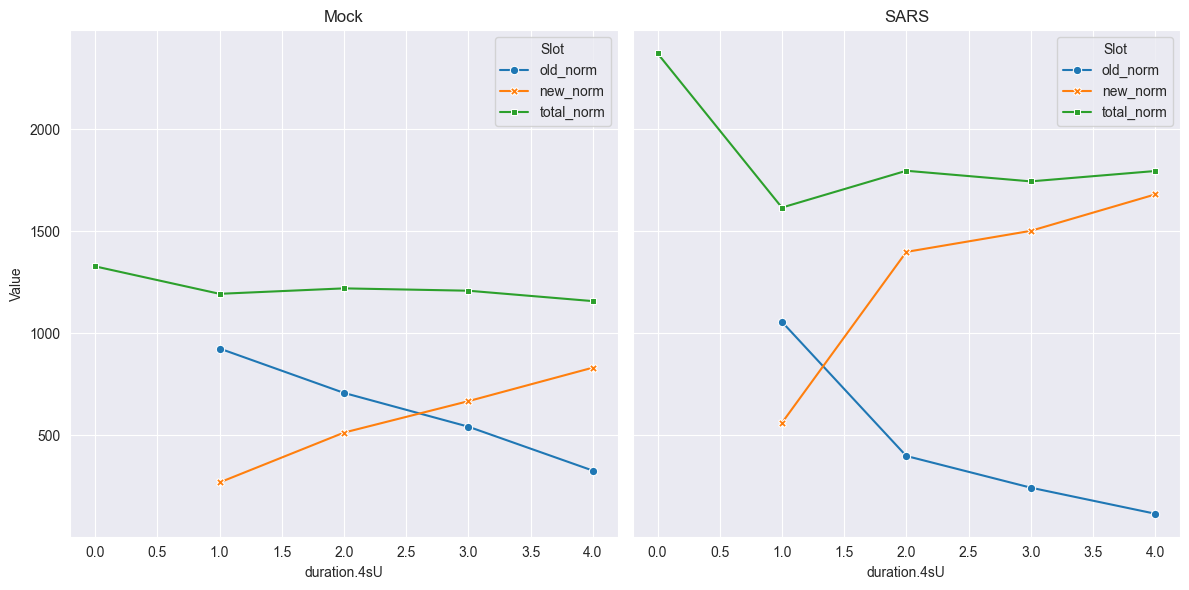

In [38]:
df = sars.get_data(mode_slot = ["old_norm", "new_norm", "total_norm"], genes = "SRSF6",
                   columns = sars.coldata["Replicate"] == "A", by_rows = True, ntr_nan=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(ax=axes[0], data=df[df['Condition'] == 'Mock'], x='duration.4sU', y='Value',
             hue='Slot', style='Slot', markers=True, dashes=False)
axes[0].set_title('Mock')
axes[0].set_xlabel('duration.4sU')
axes[0].set_ylabel('Value')

sns.lineplot(ax=axes[1], data=df[df['Condition'] == 'SARS'], x='duration.4sU', y='Value',
             hue='Slot', style='Slot', markers=True, dashes=False)
axes[1].set_title('SARS')
axes[1].set_xlabel('duration.4sU')

plt.tight_layout()
plt.show()

# get_analysis_table
As mentioned above `get_analysis_table()` is used to access data from analyses. Let's first look at the available analyses we added earlier.

In [39]:
sars.get_analyses(description = True)

{'kinetics_Mock': ['Synthesis', 'Half-life'],
 'kinetics_SARS': ['Synthesis', 'Half-life'],
 'total_1h vs no4sU.Mock': ['LFC', 'M'],
 'total_2h vs no4sU.Mock': ['LFC', 'M'],
 'total_3h vs no4sU.Mock': ['LFC', 'M'],
 'total_4h vs no4sU.Mock': ['LFC', 'M'],
 'total_1h vs no4sU.SARS': ['LFC', 'M'],
 'total_2h vs no4sU.SARS': ['LFC', 'M'],
 'total_3h vs no4sU.SARS': ['LFC', 'M'],
 'total_4h vs no4sU.SARS': ['LFC', 'M']}

Let's retrieve the kinetics for 'Mock'. Note that here `gene_info` is also added by default, which can be disabled via `with_gene_info`.

In [40]:
sars.get_analysis_table("kinetics_Mock").head()

,Symbol,Gene,Length,Type,kinetics_Mock_Synthesis,kinetics_Mock_Half-life
Symbol,,,,,,
MIB2,MIB2,ENSG00000197530,4247,Cellular,11.450151,6.685994
OSBPL9,OSBPL9,ENSG00000117859,4520,Cellular,34.006665,8.918748
BTF3L4,BTF3L4,ENSG00000134717,4703,Cellular,75.250352,4.452954
ZFYVE9,ZFYVE9,ENSG00000157077,5194,Cellular,22.187599,5.119376
PRPF38A,PRPF38A,ENSG00000134748,5274,Cellular,84.612517,2.890793


Subsetting by genes works exactly as above. `columns` and `analyses` though interpret the input as a regex by default.

In [41]:
sars.get_analysis_table(analyses="kinetics", genes=["MYC", "SRSF6"], columns="Mock", with_gene_info=False)

,kinetics_Mock_Synthesis,kinetics_Mock_Half-life
Symbol,,
MYC,2685.123425,0.521199
SRSF6,354.834337,2.479286


It is also possible to add multiple analyses not as columns, but as rows. To showcase this, we perform another analysis and drop the ones we don't need. (The `time` used here is an approximation of the effective labeling time, accounting for 4sU integration time. For more information, see the [kinetic modeling notebook](../notebook_02_kinetic_modeling))

In [42]:
sars = sars.fit_kinetics(prefix="calibrated", time=[0.000000, 0.302935, 1.686986, 1.545063, 2.600448, 4.000000, 0.000000, 0.335494, 2.026813, 1.864367, 2.926232, 4.000000]).with_dropped_analyses("total")

sars.analyses

Fitting SARS: 100%|██████████| 9162/9162 [00:15<00:00, 610.48it/s] 


['kinetics_Mock', 'kinetics_SARS', 'calibrated_Mock', 'calibrated_SARS']

Now `by_rows` makes it easier to plot the difference between the two analyses.

In [43]:
df = sars.get_analysis_table("Mock", prefix_by_analyses=False, by_rows=True, with_gene_info=False)
print(df)

              Analysis    Synthesis  Half-life
0        kinetics_Mock    11.450151   6.685994
1        kinetics_Mock    34.006665   8.918748
2        kinetics_Mock    75.250352   4.452954
3        kinetics_Mock    22.187599   5.119376
4        kinetics_Mock    84.612517   2.890793
...                ...          ...        ...
18319  calibrated_Mock   251.038294   1.814389
18320  calibrated_Mock   988.796617  15.122174
18321  calibrated_Mock    19.475085   9.253979
18322  calibrated_Mock  1005.099743   0.868803
18323  calibrated_Mock  4535.573576   0.103021

[18324 rows x 3 columns]


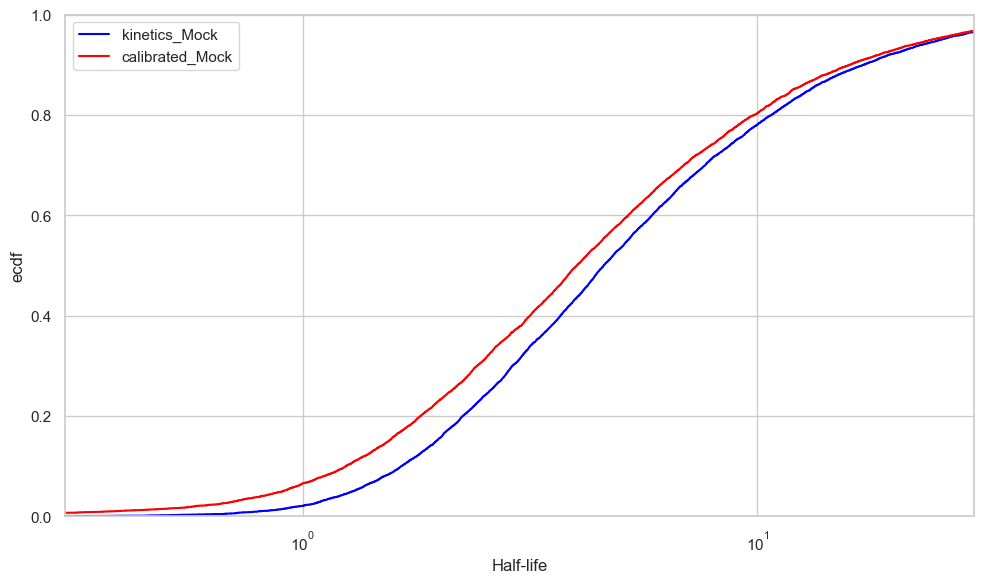

In [44]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.ecdfplot(data=df[df['Analysis'] == 'kinetics_Mock'], x='Half-life', label='kinetics_Mock', color='blue', log_scale=True)

sns.ecdfplot(data=df[df['Analysis'] == 'calibrated_Mock'], x='Half-life', label='calibrated_Mock', color='red', log_scale=True)

plt.xlim((0.3,30))

plt.xlabel('Half-life')
plt.ylabel('ecdf')

plt.legend()

plt.tight_layout()
plt.show()